In [33]:
import numpy as np
import astroscrappy
import os
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clip, mad_std
from astropy.time import Time
from astropy.table import QTable, vstack, hstack
from astropy.modeling import models, fitting

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from datetime import datetime, UTC, timezone
from pathlib import Path
from glob import glob

In [34]:
path_to_check = "ASTR481_Night2W.1/Darks/ecam-0001.fits"

if os.path.exists(path_to_check):
    print(f"The path '{path_to_check}' exists.")
else:
    print(f"The path '{path_to_check}' does not exist.")

The path 'ASTR481_Night2W.1/Darks/ecam-0001.fits' exists.


In [35]:
dark_list_1 = [
    'ASTR481_Night2W.1/Darks/ecam-0001.fits',
    'ASTR481_Night2W.1/Darks/ecam-0002.fits',
    'ASTR481_Night2W.1/Darks/ecam-0003.fits',
    'ASTR481_Night2W.1/Darks/ecam-0004.fits',
    'ASTR481_Night2W.1/Darks/ecam-0005.fits'
]

In [36]:
bias_filename = 'median_bias_file_2.fits'

In [37]:
median_dark_filename = 'median_dark_file_1.fits'

In [38]:
trimmed_darks = []

In [39]:
with fits.open(bias_filename, memmap=False) as hdul_bias:
        bias_frame = hdul_bias[0].data
        bias_trimmed = bias_frame

In [40]:
for fname in dark_list_1:
        with fits.open(fname, memmap=False) as hdul:
            data = hdul[0].data
            header = hdul[0].header

            trimmed = data[:1024, :1024]
            bias_corrected = trimmed - bias_trimmed

In [41]:
try:
    exptime = header['EXPTIME']
except KeyError:
    raise ValueError(f"Could not find exposure time in header of {fname}")

In [42]:
dark_current = bias_corrected / exptime
trimmed_darks.append(dark_current)

In [43]:
dark_stack = np.stack(trimmed_darks, axis=0)
clipped = sigma_clip(dark_stack, sigma=3, axis=0, masked=True)
median_dark_1 = np.ma.median(clipped, axis=0).filled(np.nan)

In [44]:
header = fits.Header()
header['DATE'] = (datetime.now(UTC).isoformat(), 'Date of dark frame creation (UTC)')
header['NFRAMES'] = (len(dark_list_1), 'Number of dark frames combined')
header['CLIP'] = ('Sigma-clipping', 'Combination method')
header['SIGMA'] = (3.0, 'Sigma clipping threshold')
header['TRIMMED'] = ('[:1024,:1024]', 'Trimmed region of input frames')
header['UNITS'] = ('ADU/sec', 'Units are electrons or counts per second')

In [45]:
primary = fits.PrimaryHDU(data=median_dark_1, header=header)
hdul = fits.HDUList([primary])
hdul.writeto(median_dark_filename, overwrite=True)

In [47]:
def create_median_dark(dark_list_1 = [
    'ASTR481_Night2W.1/Darks/ecam-0001.fits',
    'ASTR481_Night2W.1/Darks/ecam-0002.fits',
    'ASTR481_Night2W.1/Darks/ecam-0003.fits',
    'ASTR481_Night2W.1/Darks/ecam-0004.fits',
    'ASTR481_Night2W.1/Darks/ecam-0005.fits'
], bias_filename = 'median_bias_file_2.fits', median_dark_filename = 'median_dark_file_1.fits'):

    # Empty list for future trimmed darks.
    trimmed_darks = []

    # Loading in the bias frame.
    with fits.open(bias_filename, memmap=False) as hdul_bias:
        bias_frame = hdul_bias[0].data
        bias_trimmed = bias_frame  # Bias frame is already trimmed, set 'bias_trimmed' to 'bias_frame'

    # Processing each of the dark files.
    for fname in dark_list_1:
        with fits.open(fname, memmap=False) as hdul:
            data = hdul[0].data
            header = hdul[0].header

    trimmed = data[:1024, :1024]  # Trimmed
    bias_corrected = trimmed - bias_trimmed  # Subtracting biases from dark frames.

    # Getting the exposure time 'EXPTIME' column. 
    try:
        exptime = header['EXPTIME']
    except KeyError:
        raise ValueError(f"Could not find exposure time in header of {fname}")

    # Finding dark current by having corrected bias / exposure time. 
    dark_current = bias_corrected / exptime

    trimmed_darks.append(dark_current) # Appending dark currents to trimmed darks. 

    # Stacking and performing sigma-clipping on dark frames. 
    dark_stack = np.stack(trimmed_darks, axis=0)
    clipped = sigma_clip(dark_stack, sigma=3, axis=0, masked=True)
    median_dark_1 = np.ma.median(clipped, axis=0).filled(np.nan)

    # Creating FITs header with information.
    header = fits.Header()
    header['DATE'] = (datetime.now(UTC).isoformat(), 'Date of dark frame creation (UTC)')
    header['NFRAMES'] = (len(dark_list_1), 'Number of dark frames combined')
    header['CLIP'] = ('Sigma-clipping', 'Combination method')
    header['SIGMA'] = (3.0, 'Sigma clipping threshold')
    header['TRIMMED'] = ('[:1024,:1024]', 'Trimmed region of input frames')
    header['UNITS'] = ('ADU/sec', 'Units are electrons or counts per second')

    # Save to a FITs file. 
    primary = fits.PrimaryHDU(data=median_dark_1, header=header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_dark_filename, overwrite=True)

    return median_dark_1

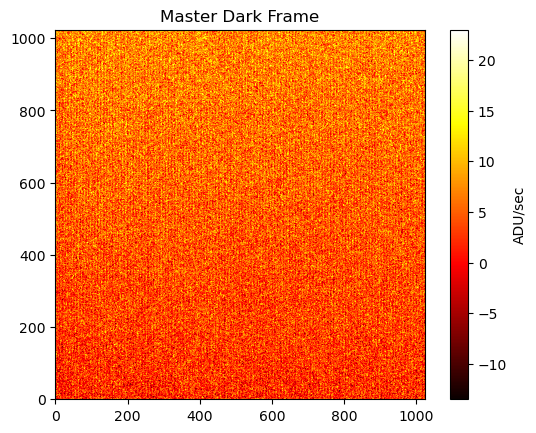

In [48]:
# Load the master dark data
median_dark_data_1 = fits.getdata('median_dark_file_1.fits')

# Plot with percentile-based stretch
plt.imshow(
    median_dark_data_1,
    origin='lower',
    cmap='hot',
    vmin=np.nanpercentile(median_dark_data_1, 5),
    vmax=np.nanpercentile(median_dark_data_1, 95)
)
plt.colorbar(label='ADU/sec')
plt.title('Master Dark Frame')
plt.show()